In [1]:
import numpy as np
from numpy import linalg as LA
from copy import deepcopy
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

from IPython.display import display as d

In [2]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0)).reshape(-1, 784, 1)
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz").reshape((-1, 1))
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0)).reshape(-1, 784, 1)
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz").reshape((-1, 1))

In [3]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 784, 1)
(12000, 1)
(1000, 784, 1)
(1000, 1)


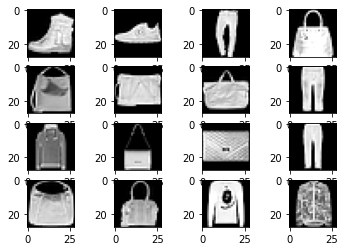

In [4]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(devxs))].reshape(28, 28))

# Q4 - Two-layer MLP

In [5]:
# Hyperparameters
learning_rate = alpha = 0.01
epochs = 50
momentum_coefficient = 0.9

Din = trainxs[0].shape[0] # trainxs.shape == (12000, 748, 1)
h1 = 200
h2 = 20
Dout = 1

In [6]:
logistic = lambda z: np.exp(np.fmin(z, 0)) / (1 + np.exp(-np.abs(z)))
logistic_prime = lambda z: logistic(z) * (1 - logistic(z))

def initTwoLayerPerceptron(hids):
    m = {
        "W1": np.random.random((hids, 784)) / 100,
        "b1": np.random.random((hids)) / 100,
        "w2": np.random.random((hids)) / 100,
        "b2": np.zeros(1)
    }
    return m

def mshow(m):
    for k, v in m.items():
        print(k, v.shape)

In [7]:
def f(m, x):
    z1 = (m["W1"] @ x).squeeze() + m["b1"]
    a1 = logistic(z1)
    z2 = m["w2"].dot(a1) + m["b2"]
    a2 = logistic(z2)
    return a2.item()

In [8]:
def p(m, x):
    if f(m, x) >= 0.5:
        return 1
    return 0

In [9]:
def accuracy(m, xs, ys):
    total = 0.
    for x, y in zip(xs, ys):
        if p(m, x) == y:
            total += 1
    return total / xs.shape[0]

In [10]:
mlp = initTwoLayerPerceptron(200)
mshow(mlp)
accuracy(mlp, trainxs, trainys)

W1 (200, 784)
b1 (200,)
w2 (200,)
b2 (1,)


0.5

In [12]:
def loss(m, x, y):
    y_pred = f(m, x)
    if y_pred == 0 or y_pred == 1:
        return np.array([[0]])
    return (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))

def loss_prime(m, y_pred, y):
    return (-y/y_pred) + (1-y)/(1-y_pred)

In [13]:
somei = 5
somex = trainxs[somei]
somey = trainys[somei]

In [14]:
def zero(m):
    gradm = deepcopy(m)
    gradm["W1"].fill(0)
    gradm["b1"].fill(0)
    gradm["w2"].fill(0)
    gradm["b2"].fill(0)
    return gradm

In [15]:
mshow(zero(mlp))

W1 (200, 784)
b1 (200,)
w2 (200,)
b2 (1,)


In [64]:
fprime = lambda m, x, y: fprimeg(zero(m), m, x, y)
def fprimeg(gradm, m, x, y):
    # Forward Pass
    z1 = (m["W1"] @ x).squeeze() + m["b1"]
    a1 = logistic(z1)
    z2 = m["w2"].dot(a1) + m["b2"]
    a2 = logistic(z2)
    
    # Backward Pass
    gradz2 = (a2 - y) # = loss_prime(a2, y) * logistic_prime(z2)
    gradm["b2"] += gradz2
    gradm["w2"][:] += np.multiply(gradz2, a1)
    assert gradm["b2"].shape == m["b2"].shape
    assert gradm["w2"].shape == m["w2"].shape
    
    # FIX SHAPES
    gradz1 = np.multiply(gradz2 * m["w2"], logistic_prime(z1))
    gradm["b1"] = gradz1
    gradm["W1"] = np.dot(gradz1.reshape((-1, 1)), x.T)
    assert gradm["b1"].shape == m["b1"].shape
    assert gradm["W1"].shape == m["W1"].shape
    return gradm

In [65]:
anfprime_i = fprime(mlp, somex, somey)

In [33]:
def flatten(m):
    toflatten = (m["W1"], m["b1"], m["w2"], m["b2"])
#     print([s.shape for s in toflatten])
    vec = np.zeros(sum([x.size for x in toflatten]))
    offset = 0
    for param in toflatten:
        vec[offset:offset + param.size] = param.reshape(param.size)
        offset += param.size
    return vec

def unflatten(m, vec):
    params = (m["W1"], m["b1"], m["w2"], m["b2"])
    offset = 0
    for param in params:
        param[:] = vec[offset:offset + param.size].reshape(param.shape)
        offset += param.size
    return m

# d(unflatten(mlp, flatten(mlp))["w2"][0].all() == mlp["W1"][0].all())

In [20]:
fdfprime = lambda m, x, y: fdfprimeg(zero(m), m, x, y)
def fdfprimeg(gradm, m, x, y):
    epsilon = 1e-6
    vecm = flatten(m)
    vecgradm = flatten(gradm)
    for i in range(vecm.size):
        wi = vecm[i]
        vecm[i] += epsilon
        u = loss(unflatten(zero(m), vecm), x, y)
        vecm[i] = wi
        vecm[i] -= epsilon
        l = loss(unflatten(zero(m), vecm), x, y)
        vecgradm[i] = (u - l) / (2 * epsilon)
        
        vecm[i] = wi
    return unflatten(gradm, vecgradm)
if fdfprime_i:
# fdfprime_i = fdfprime(mlp, somex, somey)
    fdfprime_i

{'W1': array([[-5.98351924e-06, -5.98351924e-06, -5.98351924e-06, ...,
         -5.98351924e-06, -5.98351924e-06, -5.98351924e-06],
        [-7.17981230e-06, -7.17981230e-06, -7.17981230e-06, ...,
         -7.17981230e-06, -7.17981230e-06, -7.17981230e-06],
        [-1.20554677e-05, -1.20554677e-05, -1.20554677e-05, ...,
         -1.20554677e-05, -1.20554677e-05, -1.20554677e-05],
        ...,
        [-1.41898437e-05, -1.41898437e-05, -1.41898437e-05, ...,
         -1.41898437e-05, -1.41898437e-05, -1.41898437e-05],
        [-9.91978721e-06, -9.91978721e-06, -9.91978721e-06, ...,
         -9.91978721e-06, -9.91978721e-06, -9.91978721e-06],
        [-8.63689675e-06, -8.63689675e-06, -8.63689675e-06, ...,
         -8.63689675e-06, -8.63689675e-06, -8.63689675e-06]]),
 'b1': array([-6.68155808e-05, -8.01747557e-05, -1.34618899e-04, -1.62176050e-04,
        -1.08843407e-04, -2.25589825e-05, -1.42048651e-04, -5.32164590e-05,
        -7.62440666e-05, -6.21913354e-05, -7.71137876e-05, -1.264

In [68]:
anfprime_i = fprime(mlp, somex, somey)
for k in mlp:
    print("max diff of grad", k, (fdfprime_i[k] - anfprime_i[k]).max())

max diff of grad W1 1.7174252146291702e-10
max diff of grad b1 1.3346899494360957e-10
max diff of grad w2 1.245988867637493e-10
max diff of grad b2 -4.902467320988535e-11


## Q4.1 - Gradient Descent Comparison